# Modern Hopfield Network
In this notebook we study Modern Hopfield Networks (aka Dense Associative Memories). The notebook is divided into 2 parts. In the first part, we examine the discrete modern Hopfield Networks, where the elements of both the stored patterns and the retrieved patterns are either -1 and 1. In the second part, we focus on conituous modern Hopfield Network, from which a link can be made to transformers, specifically the attention mechanism.

## Setup
Import all the necessary modules used throughout this notebook and define some methods to visualize the images and evolution of the energy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from keras.datasets import fashion_mnist
from scipy.special import logsumexp, softmax

rng = np.random.default_rng()

In [2]:
def plot_images(images, titles=None, filename=None, cmap="binary"):
    images = np.asarray(images)
    C, R = [1, 1, *images.shape[:-1]][-2:]
    if titles is None:
        titles = [None] * C
    images = images.reshape((C, R, 28, 28))
    fig, axes = plt.subplots(
        R, C, squeeze=False, gridspec_kw={"wspace": 1, "hspace": 0.05}
    )
    for c, title in enumerate(titles):
        if title is not None:
            axes[0, c].set_title(title)
        for r in range(R):
            axes[r, c].imshow(images[c, r], cmap=cmap)
            axes[r, c].axis("off")
    if filename is not None:
        plt.savefig(f"{filename}.svg")
    plt.show()


def plot_energies(energies, filename=None):
    if energies.ndim == 1:
        energies = np.expand_dims(energies, 0)
    fig, ax = plt.subplots()
    ax.plot(energies.T)

    ax.set_title("(Log-negative) energy evolution of the states")

    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"{filename}.svg")
    plt.show()


def plot_grid(imgs, class_names, cmap="binary"):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].reshape(28, 28), cmap=cmap)
        plt.xlabel(class_names[i])
    plt.tight_layout()
    plt.show()

# Discrete Modern Hopfield Network
In discrete case, all patterns are binary. The energy function is given by
\begin{equation}
E = -\sum_{i=1}^NF(x_i^\top\xi)
\end{equation}
where $F$ is an interaction function. In this assignment we will use the exponential interaction function. Thus the energy function if given by
\begin{equation}
E = -\sum_{i=1}^N\exp(x_i^\top\xi)=-\exp(\text{lse}(1,X^\top\xi)).
\end{equation}


### Loading data
We start by loading the fashion MNIST dataset. The dataset consistsof a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. In order to apply discrete modern Hopfield networks, we also need to preprocess the images such that each element is either -1 or 1.

For each label we select one example, leading to 10 patterns in total.

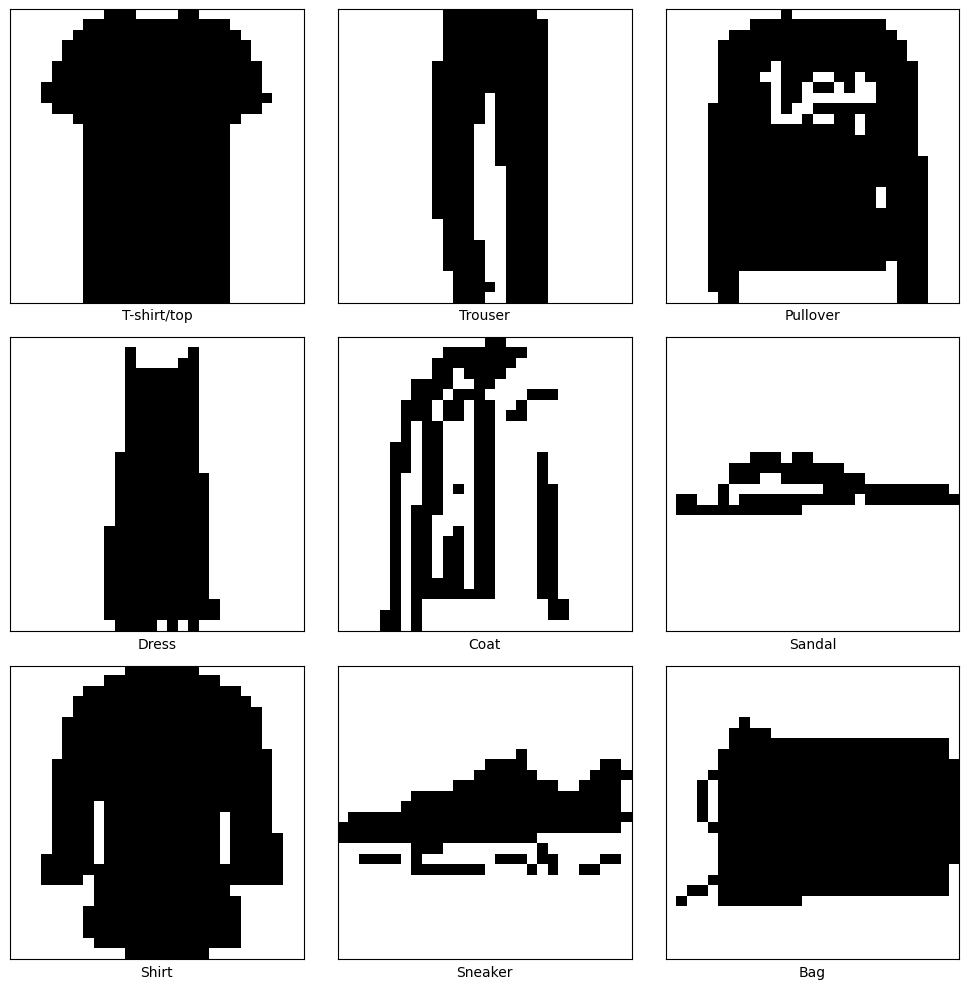

In [3]:
# Load the Fashion MNIST dataset. Only the test set is used.
_, (images, labels) = fashion_mnist.load_data()

images = {d: images[labels == d] for d in range(10)}  # Store images by class label
targets = np.asarray([images[d][0] for d in range(10)]).reshape(10,-1)  # Select one image of each class as a target pattern for the Hopfield network


def convert_to_monochrome(image, threshold=50):
    """Convert grayscale images to monochrome (binary) images."""
    return ((image > threshold).astype(np.uint8) - 0.5) * 2


targets_monochrome = np.array([convert_to_monochrome(img) for img in targets])

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plot_grid(targets_monochrome, class_names)

### Build Discrete Modern Hopfield Network from Scratch

We define a class for discrete modern Hopfield network.

In [4]:
class Discrete_MHN:
    def __init__(self, stored_patterns):
        """Initialize a new Hopfield network for the given target patterns."""
        self.targets = np.atleast_2d(stored_patterns)
        self.N = self.targets.shape[0]
        self.D = self.targets.shape[1]
        self.rng = np.random.default_rng()

    def simulate(self, data, num_iter=10):
        """Simulate the state evolution of the Hopfield network for the given input data."""

        data = np.atleast_2d(np.asarray(data, dtype=float))

        # Collect all encountered states and their energy
        states = np.empty((*data.shape, num_iter + 1))
        log_energies = np.empty((data.shape[0], num_iter + 1))

        s = np.copy(data)
        states[:, :, 0] = s
        log_energies[:, 0] = self.log_energy(s)
        for t in range(num_iter):
            for d in self.rng.permutation(self.D):
                s = self._update(s, d)
            states[:, :, t + 1] = s
            log_energies[:, t + 1] = self.log_energy(s)
        return np.squeeze(states), np.squeeze(log_energies)

    def _update(self, s, d):
        """Update the d-th element of the states according to the update rule."""
        s_plus = np.copy(s)
        s_plus[:, d] = 1
        s_minus = np.copy(s)
        s_minus[:, d] = -1
        s[:, d] = np.where(self.log_energy(s_plus) > self.log_energy(s_minus), 1, -1)
        return s

    def log_energy(self, s):
        """Calculate the log-negative energy of a given state s."""
        s = np.atleast_2d(s)
        return logsumexp(self.targets @ s.T, axis=0)

### Training
Add some noise to the images and train the network.

In [5]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 6.5 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 10 # @param {type:"slider", min:1, max:100, step:1}

In [6]:
images_noisy = np.clip(targets_monochrome + rng.normal(scale=noise_level, size=targets_monochrome.shape), -1, 1)  # Create noisy images

net = Discrete_MHN(targets_monochrome)
states, energies = net.simulate(images_noisy, num_iter=num_iter)

Plot the retrived patterns and evolution of the log-negative energy during iterations. NOTE that we use the log-negative energy because computing the exact energy can lead to overflow error. What can you say about the results?

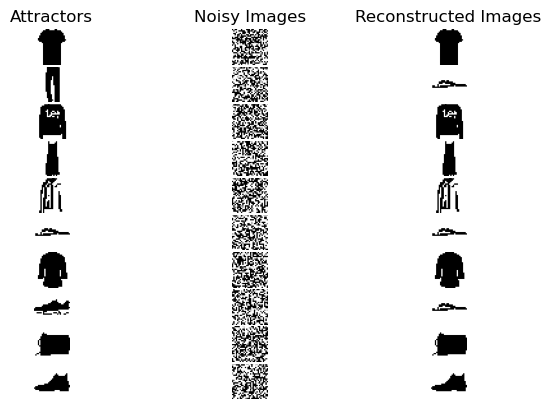

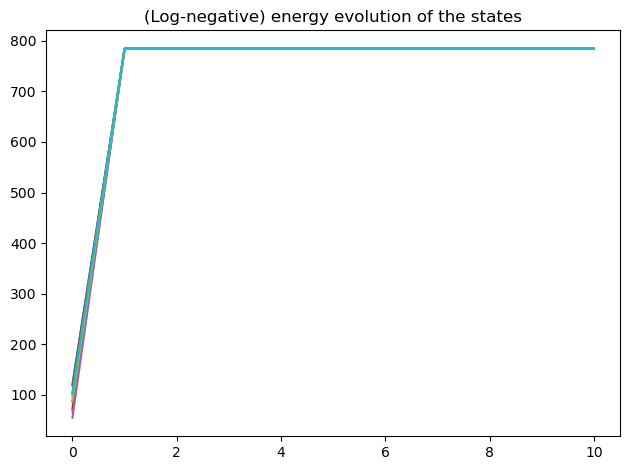

In [7]:
plot_images([targets_monochrome, images_noisy, states[:,:,-1]], ["Attractors", "Noisy Images", "Reconstructed Images"])
plot_energies(energies)

# Continuous Modern Hopfield Network
Modern Hopfiled Networks can be generalized to store continuous-valued patterns.


### Build Continuous Modern Hopfield Network from Scratch
Define a class for continuous modern Hopfield network.

In [8]:
class Continuous_MHN:
    def __init__(self, stored_patterns, beta):
        """Initialize a new Hopfield network for the given target patterns."""
        self.targets = np.atleast_2d(np.asarray(stored_patterns, dtype=float))
        self.N = self.targets.shape[0]
        self.D = self.targets.shape[1]
        self.rng = np.random.default_rng()
        self.beta = beta

    def simulate(self, data, num_iter=10):
        """Simulate the state evolution of the Hopfield network for the given input data."""

        data = np.atleast_2d(np.asarray(data, dtype=float))

        # Collect all encountered states and their energy
        states = np.empty((*data.shape, num_iter + 1))
        energies = np.empty((data.shape[0], num_iter + 1))

        s = np.copy(data)  # Shape (P, D)
        states[:, :, 0] = s
        energies[:, 0] = self.energy(s)
        for t in range(num_iter):
            s = self._update(s)
            states[:, :, t + 1] = s
            energies[:, t + 1] = self.energy(s)
        return np.squeeze(states), np.squeeze(energies)

    def _update(self, s):
        """Update the d-th element of the states according to the update rule."""
        s_new = (self.targets.T @ softmax(self.beta * (self.targets @ s.T), axis=0)).T
        return s_new

    def energy(self, s):
        """Calculate the energy of a given state s."""
        s = np.atleast_2d(s)
        e1 = -logsumexp(self.beta * (self.targets @ s.T), axis=0) / self.beta
        e2 = 0.5 * np.diagonal(s @ s.T)
        e3 = np.log(self.N) / self.beta
        e4 = 0.5 * np.max(np.linalg.norm(self.targets, axis=1)) ** 2
        return e1 + e2 + e3 + e4

### Preprocess data
Normalize data and create noisy data by masking the bottom part of the images.

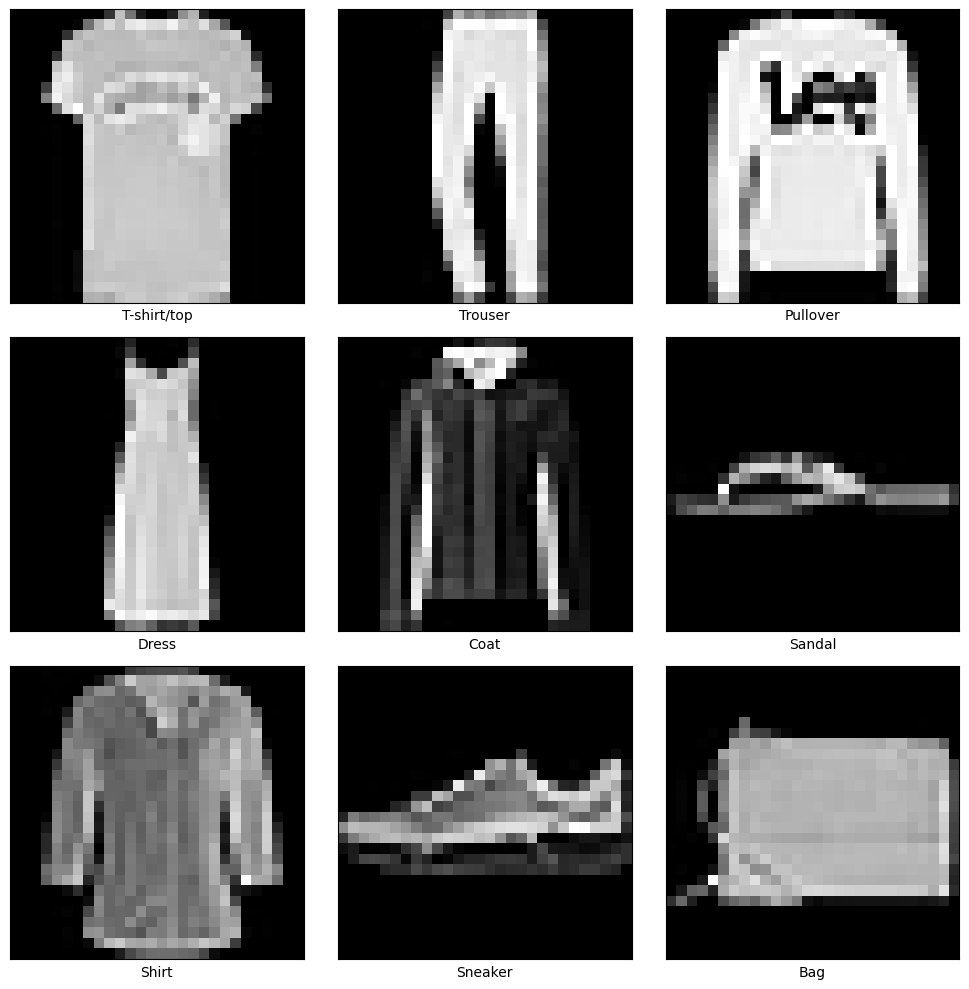

In [9]:
def normalize(data):
    """Normalize the given data along the 2nd dimension."""
    data = np.atleast_2d(np.asarray(data, dtype=float))
    x = np.copy(data)
    norm = np.linalg.norm(x, axis=1)
    for i in range(x.shape[0]):
        if norm[i] == 0:
            x[i, :] = x[i, :]
        else:
            x[i, :] = x[i, :] / norm[i]
    return x


targets_normalized = normalize(targets)
plot_grid(targets_normalized, class_names, cmap="gray")

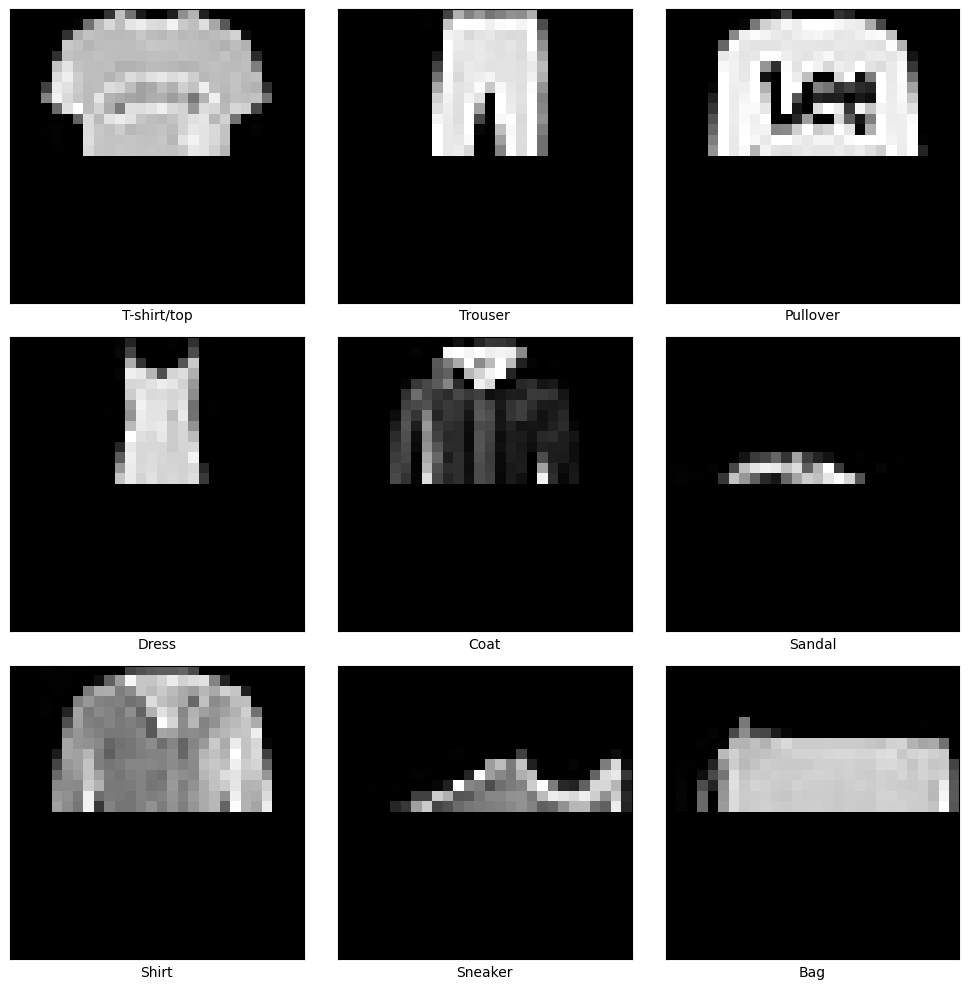

In [10]:
def noisy(data):
    """Mask the images from the 14th row."""
    data = np.atleast_2d(np.asarray(data, dtype=float))
    data = data.reshape((-1, 28, 28))
    data[:, 14:, :] = 0
    return data.reshape((data.shape[0], -1))


targets_noisy = noisy(targets)  # Mask the bottom part of the images
targets_noisy = normalize(targets_noisy)

plot_grid(targets_noisy, class_names, cmap="gray")

### Training
Create a continuous modern Hopfield network and retrieve the patterns using the noisy data. You can also play around with the beta values. Plot the retrived patterns and evolution of the energy during iterations. What can you say about the results?

In [11]:
beta = 1
num_iter = 10

net = Continuous_MHN(targets_normalized, beta = beta)
states, energies = net.simulate(targets_noisy, num_iter=num_iter)

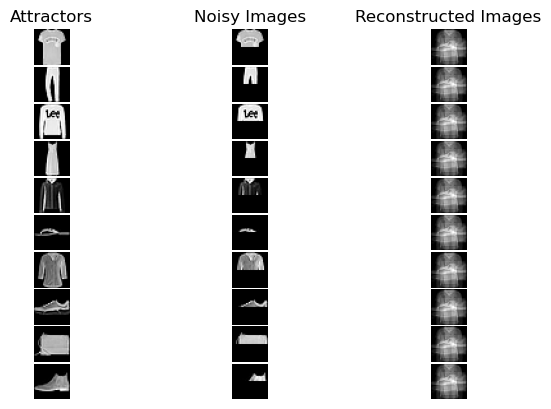

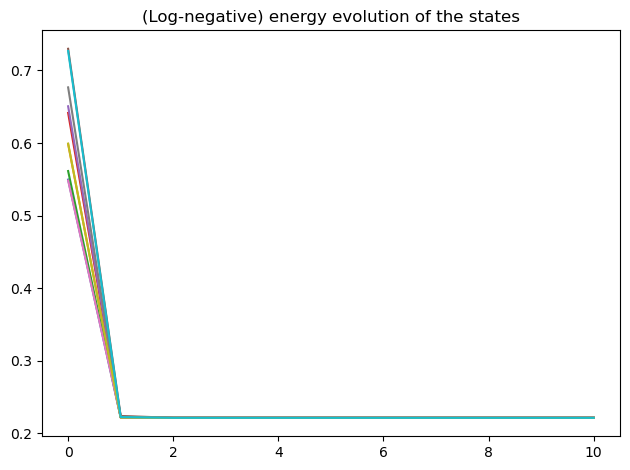

In [12]:
plot_images([targets_normalized, targets_noisy, states[:,:,-1]], ["Attractors", "Noisy Images", "Reconstructed Images"], cmap='gray')
plot_energies(energies)